# Inflation, Unemploymet and Real GDP

In this project we aim to examine the historical trends in inflation rates, unemployment and GDP in Denmark. 

Inflation is the rate at which the general prices for goods and services change increase, corresponding to a decrease in purchasing power of money. Gross Domestic Product (GDP) is a measure of a country's yearly production. We use this to assess the econimic well-being in Denmark in a given time-period.


Data is retrieved from Statitics Denmark. We utilize API's to retrieve data on inflation rates (PRIS111) and unemployment (AULP01). Data on GDP (NAN1) is retrieved from CSV file. Yearly inflation rates are set as end-of-year rates (M12).

Imports and load of relevant libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pandas_datareader # install with `pip install pandas-datareader`
from dstapi import DstApi # install with `pip install git+https://github.com/alemartinello/dstapi`

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject as dp

plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

# Reading and cleaning data (inflation)

In [2]:
# Defining dictionary mappings for renaming and processing
columns_dict = {'VAREGR': 'variable', 'ENHED': 'unit', 'TID': 'Year', 'INDHOLD': 'Inflation rate'}
var_dict = {'00 Consumer price index, total': 'Y'}
unit_dict = {'Index': 'Indexnumber', 'Percentage change compared to previous month (per cent)': 'pct month', 'Percentage change compared to same month the Year before (per cent)': 'pct Year'}

# Retrieving and processing inflation data from Statistics Denmark API
PRIS111_api = DstApi('PRIS111')
params = PRIS111_api._define_base_params(language='en')
PRIS111 = PRIS111_api.get_data(params)
# Renaming columns of the DataFrame PRIS111. 
PRIS111.rename(columns=columns_dict, inplace=True)
for key, value in var_dict.items():
    PRIS111['variable'].replace(key, value, inplace=True)
for key, value in unit_dict.items():
    PRIS111['unit'].replace(key, value, inplace=True)

# Converting our dataframes from string values to numeric values. Sorting Dataframe by year
PRIS111['Year'] = pd.to_numeric(PRIS111['Year'].str.replace('M12', ''), errors='coerce')
PRIS111['Inflation rate'] = pd.to_numeric(PRIS111['Inflation rate'], errors='coerce')
PRIS111 = PRIS111[(PRIS111['variable'] == 'Y') & (~PRIS111['unit'].isin(['Indexnumber', 'pct month'])) & (PRIS111['Year'].notna()) & (PRIS111['Year'] >= 2007) & (PRIS111['Year'] != 2023)]
PRIS111.sort_values(by='Year', inplace=True)
PRIS111['Year'] = PRIS111['Year'].astype(int)


## Displaying data

In [3]:
PRIS111.head(5)

,variable,unit,Year,Inflation rate
111067,Y,Percentage change compared to same month the y...,2007,2.3
10738,Y,Percentage change compared to same month the y...,2008,2.4
15057,Y,Percentage change compared to same month the y...,2009,1.4
187928,Y,Percentage change compared to same month the y...,2010,2.8
128829,Y,Percentage change compared to same month the y...,2011,2.4


# Plotting data

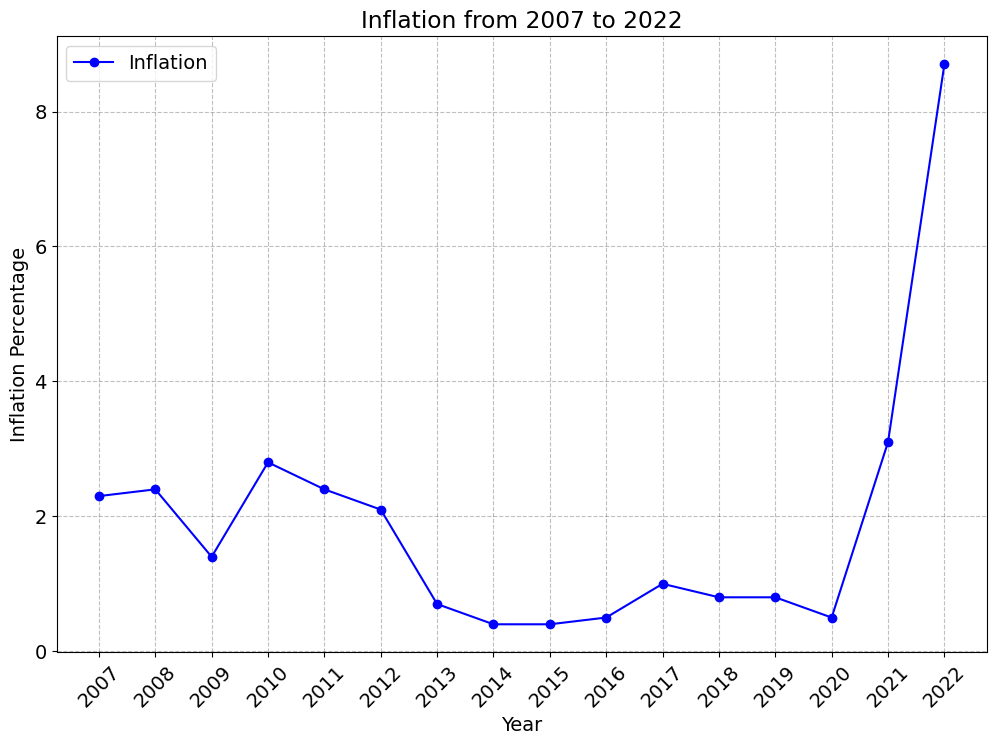

In [4]:
# Plotting inflation data
plt.figure(figsize=(12, 8))
plt.plot(PRIS111['Year'], PRIS111['Inflation rate'], marker='o', linestyle='-', color='blue', label='Inflation')
plt.title('Inflation from 2007 to 2022')
plt.xlabel('Year')
plt.ylabel('Inflation Percentage')
plt.xticks(PRIS111['Year'].unique(), rotation=45)
plt.legend()
plt.grid(True)
plt.show()


We observe inflation in Denmark in the period 2007-22. Initially, it remained moderate, hovering between 2.3% and 2.8% from 2007 to 2011. This period saw generally stable economic conditions. A significant drop occurred between 2012 and 2015, with inflation rates plummeting to lows of 0.4% and 0.7%, indicative of a sluggish economic environment possibly influenced by global financial challenges. From 2016 to 2019, inflation was consistently mild, ranging between 0.5% and 1.0%, suggesting stable but slow economic growth. However, a sharp increase is observed in 2021 and 2022, with rates jumping to 3.1% and 8.7%. The relatively large increase in inflation to 8.7 pct. was mostly due to changes in prices in residential use, electricity, and heating. 

NB: we restrict ourselves to 2022, since there's not yet data for unemployment in 2023. In December 2023, inflation drops to 0.7 pct., which was largely due to decreasing energy prices. 

# Reading and cleaning data (unemployment)

In [5]:
# Retrieving and processing data for Unemployment
FT_api = DstApi('AULP01')
params = FT_api._define_base_params(language='en')
params['variables'][0]['values'] = ['000']
params['variables'][1]['values'] = ['TOT']
params['variables'][2]['values'] = ['TOT']
params['variables'][3]['values'] = ['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']
unemp = FT_api.get_data(params=params)
unemp.rename(columns={'TID':'Year','INDHOLD':'Unemployment'}, inplace=True)
unemp['Year'] = pd.to_numeric(unemp['Year'], errors='coerce')
unemp['Unemployment'] = pd.to_numeric(unemp['Unemployment'], errors='coerce')
unemp.sort_values(by='Year', inplace=True)

## Merging inflation- and unemployment data from Statistics Denmark

In [6]:
# Merging and sorting data
merged = pd.merge(PRIS111, unemp, how='left', on=['Year'])
merged.sort_values(by='Year', inplace=True)

In [7]:
merged = pd.merge(PRIS111, unemp, how='left', on='Year')
merged.sort_values(by='Year', inplace=True)
Combined_data = merged[['Year', 'Inflation rate', 'Unemployment']]

# Displaying merged data

In [8]:
# Displaying the first few rows of the DataFrame
Combined_data.head(2)

,Year,Inflation rate,Unemployment
0,2007,2.3,3.6
1,2008,2.4,2.6


# Plotting the combined data

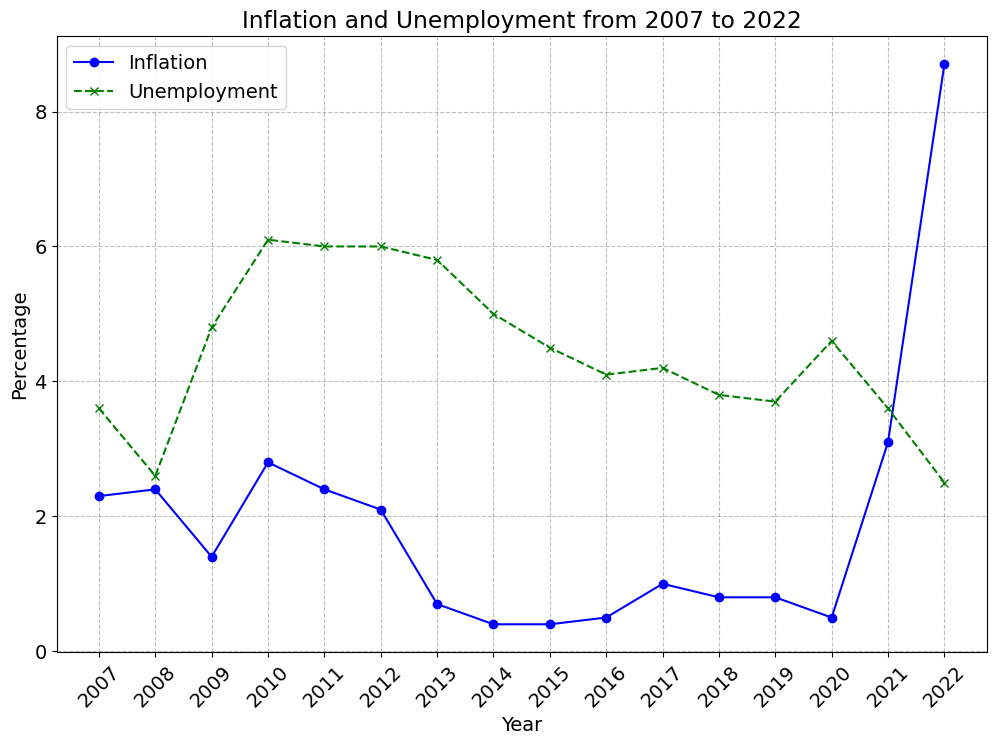

In [9]:
# Plotting the merged data
plt.figure(figsize=(12, 8))
plt.plot(Combined_data['Year'], Combined_data['Inflation rate'], marker='o', linestyle='-', color='blue', label='Inflation')
plt.plot(Combined_data['Year'], Combined_data['Unemployment'], marker='x', linestyle='--', color='green', label='Unemployment')
plt.title('Inflation and Unemployment from 2007 to 2022')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.xticks(Combined_data['Year'].unique(), rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In Denmark from 2007 to 2022, inflation and unemployment trends mirrored broader economic conditions. Initially, moderate inflation between 2.3% and 2.8% from 2007 to 2011 coincided with stable unemployment rates, peaking slightly in 2010 at 6.1%, reflecting the global economic downturn. As inflation rates plummeted to as low as 0.4% and 0.7% between 2012 and 2015, a sluggish economic environment persisted, marked by unemployment rates stabilizing around 6%. From 2016 to 2019, both inflation and unemployment displayed steady trends; mild inflation between 0.5% and 1.0% paired with a declining unemployment rate, stabilizing around 4%, suggested a period of economic recovery. The sharp inflation increase in 2021 and 2022 to 3.1% and 8.7%, primarily driven by spikes in residential use costs, electricity, and heating, occurred alongside a substantial drop in unemployment to a record low of 2.6%, indicating a complex interplay of rapid price increases and tightening labor markets. Thus it may seem, that inflation and unemployment has an inverse relationship.

## Real GDP for Denmark

In [10]:
# Importing data from CSV file 'Real GDP'
GDP = pd.read_csv('GDP new1.csv',delimiter=';')

## Display the data set

In [11]:
#Here we display the data to see the values for Real GDP
GDP.head(10)

,Year,Real GDP
0,2007,1879.0
1,2008,1869.4
2,2009,1777.7
3,2010,1810.9
4,2011,1835.1
5,2012,1839.3
6,2013,1856.5
7,2014,1886.5
8,2015,1930.7
9,2016,1993.4


In [12]:
# We display our combined data for the inflation- and unemployment rate. 
Combined_data.head(2)

,Year,Inflation rate,Unemployment
0,2007,2.3,3.6
1,2008,2.4,2.6


We combine all three dataframes Real GDP with inflation rate and unemployment rate

In [13]:
# We join/ merge our dataframe real GDP with our combined data which contains dataframe inflation- and unemployment rate. 
merging = pd.merge(GDP, Combined_data, how='left', on=['Year'])

Combined_data1 = merging[["Year", "Inflation rate", "Unemployment", "Real GDP"]]
Combined_data1.head(5)

,Year,Inflation rate,Unemployment,Real GDP
0,2007,2.3,3.6,1879.0
1,2008,2.4,2.6,1869.4
2,2009,1.4,4.8,1777.7
3,2010,2.8,6.1,1810.9
4,2011,2.4,6.0,1835.1


In [14]:
# We convert 'Year' column to integer if it's stored as string. 
Combined_data1['Year'] = pd.to_numeric(Combined_data1['Year'], errors='coerce')

# Here we do the same. Converting 'Real GDP', 'Inflation rate' and 'Unemployment' to a numeric type. 
Combined_data1['Real GDP'] = pd.to_numeric(Combined_data1['Real GDP'], errors='coerce')
Combined_data1['Inflation rate'] = pd.to_numeric(Combined_data1['Inflation rate'], errors='coerce')
Combined_data1['Unemployment'] = pd.to_numeric(Combined_data1['Unemployment'], errors='coerce')


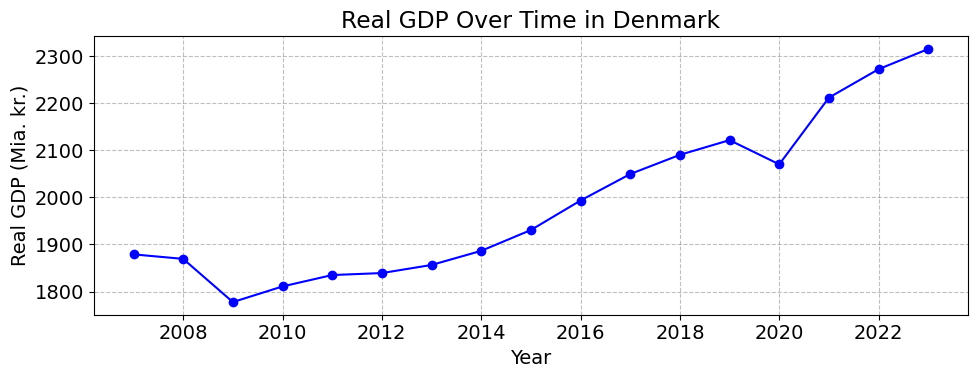

In [15]:
# We sort our dataframe 'Combined data' by the 'Year' column
Combined_data1.sort_values(by='Year', inplace=True)

# Plotting the graph for Real GDP
plt.figure(figsize=(10, 4))
plt.plot(GDP['Year'], GDP['Real GDP'], marker='o', color='blue')
plt.ylabel('Real GDP (Mia. kr.)')
plt.title('Real GDP Over Time in Denmark')
plt.xlabel('Year')
plt.grid(True)  # Add gridlines
plt.tight_layout()
plt.show()

The graph above shows the development of GDP from 2007 to 2023. In the graph, we can divide it into the following sub-periods. From 2007 to 2009, there is a significant decline, which is due to the financial crisis. GDP decreases by 100 billions DKK. Next, there is a trend of a significant increase in GDP from 2009 to 2019. GDP increases by 344 billions DKK. From 2019 to 2020, there is a slight decrease in GDP due to COVID-19 and decreases by 51.4 billions DKK. The curve is increasing again from 2020 onwards until 2023.

## Analyzing the data

In [16]:
# We calculate average Unemployment Rate
average_unemp = Combined_data1['Unemployment'].mean()

# Doing the same. Calculate average Inflation Rate
average_inf = Combined_data1['Inflation rate'].mean()

# Printing the results making sure it only prints 2 decimals.  
print("Average Unemployment Rate:", round(average_unemp,2))
print("Average Inflation Rate:", round(average_inf,2))



Average Unemployment Rate: 4.43
Average Inflation Rate: 1.89


Here we see that the average unemployment rate and the inflation rate for the period 2007-2022 are 4.43 pct. and 1.89 pct.

In [17]:
#Calculating the correlation between Real GDP and Inflation
corr_GDP_inf = Combined_data1['Real GDP'].corr(Combined_data1['Inflation rate'])
print("Correlation between GDP and Inflation Rate:", round(corr_GDP_inf,2))

Correlation between GDP and Inflation Rate: 0.41


The data shows a positive correlation between real GDP and the inflation rate. According to the Phillips curve, inflation rises as demand for labor increases. In this scenario, workers can demand higher wages, resulting in higher production prices. This, in turn, leads to an increase in capital and labor, resulting in a higher real GDP.

In [18]:
#Calculate the correlation between Real GDP and unemployment rates.

corr_GDP_unemp = Combined_data1['Unemployment'].corr(Combined_data1['Real GDP'])

# Print the correlation coefficient
print("Correlation coefficient between Real GDP and Unemployment:", round(corr_GDP_unemp,2))

Correlation coefficient between Real GDP and Unemployment: -0.65


We see a positive correlation between Real GDP and Unemployment. As Real GDP increases, Unemployment tends to decrease, and vice versa. Due the Phillips curve there is an inverse relationship between inflation and unemployment in the short run. When the economy is performing well and Real GDP is increasing, there tends to be higher demand for goods and services, leading to increased production and employment opportunities. As more people find jobs, the unemployment rate decreases. Conversely, during economic downturns, Real GDP decreases, leading to lower demand for goods and services and, consequently, higher unemployment rates. 

In [19]:
# Calculate the correlation between inflation rates and unemployment rates
corr_inf_unemp = Combined_data1['Inflation rate'].corr(Combined_data1['Unemployment'])

# Print the correlation coefficient
print("Correlation coefficient between Inflation rate and Unemployment rate:", round(corr_inf_unemp,2))

Correlation coefficient between Inflation rate and Unemployment rate: -0.39


A negative correlation between inflation and unemployment is observed to be -0.39. As described above, according to the Phillips curve, high inflation will lead to low unemployment. This is attributed to several factors, but the primary explanation lies in the increased demand for labor in the labor market. More individuals are employed, and as a result, businesses can offer higher wages to employees, resulting in low unemployment. It should be noted that there are multiple factors at play. This is a simplified version/explanation.

In [20]:
# Calculate the annual growth rate of GDP (percentage change in GDP)
GDP['GDP_growth'] = GDP['Real GDP'].pct_change() * 100 

# Create a new DataFrame with Year and GDP Growth Rate
GDP_growth_ = pd.DataFrame({'Year': GDP['Year'], 'GDP_growth': GDP['GDP_growth']})

# Drop the first row, 2007, since it will have NaN value for growth rate
GDP_growth_ = GDP_growth_.dropna()

# Print the DataFrame with Year and GDP Growth Rate
print(round(GDP_growth_,2))

    Year  GDP_growth
1   2008       -0.51
2   2009       -4.91
3   2010        1.87
4   2011        1.34
5   2012        0.23
6   2013        0.94
7   2014        1.62
8   2015        2.34
9   2016        3.25
10  2017        2.82
11  2018        1.99
12  2019        1.49
13  2020       -2.42
14  2021        6.84
15  2022        2.73
16  2023        1.89


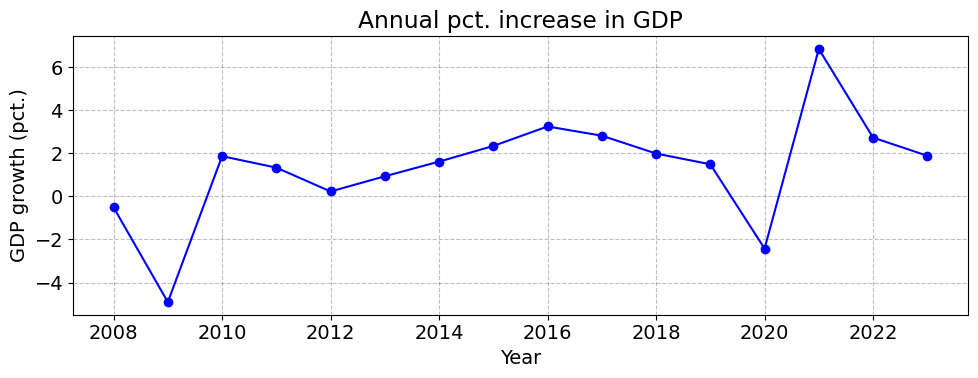

In [21]:
GDP_growth_.sort_values(by='Year', inplace=True)

# Plotting the graph for annual pct. increas in GDP
plt.figure(figsize=(10, 4))
plt.plot(GDP_growth_['Year'], GDP_growth_['GDP_growth'], marker='o', color='blue')
plt.ylabel('GDP growth (pct.)')
plt.title('Annual pct. increase in GDP')
plt.xlabel('Year')
plt.grid(True)  # Add gridlines
plt.tight_layout()
plt.show()

The graph shows the annual percentage increase in GDP. The curve shows significant volatility throughout the period from 2008 to 2023. As previously explained in the figure illustrating Real GDP over time in Denmark, we can highlight 2009, 2020, and 2022. In 2009, a sharp decline of 4.91 percent is observed, attributed to Denmark being hit by the financial crisis. This had serious consequences on the Danish economy, including GDP. From 2009 to 2010, there is an increase of 1.87 percent, which begins to stabilize the economy. In 2020, COVID-19 hits again, impacting the economy and GDP. However, we quickly bring the economy back to a relatively stable level, and in 2021, we see an increase of 6.84 percent. This is the highest increase observed on the graph so far. In 2022, the war in Ukraine begins, affecting several countries due to the high energy and gas prices.

# Conclusion